# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the period that we are predicting for.

## Update the John Hopkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [1]:
# import libraries

# local function calls
import arima_grid_search as ags
import load_data as ld
import multi_step_forecast as msf
import stationarity as st
import summarize
import test_prediction_save_forecast_1day as tpsf1

# Standard libararies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Prepare arguments for driver

In [2]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\Lindsay Moir\OneDrive\Documents\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\Lindsay Moir\OneDrive\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (10,2,1), 
            'order_list': [],
            'p_values': range(5,9),
            'd_values': range(1,3),
            'q_values': range(1,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '06-30-2021'}

## Load John Hopkins data

The "data date" is 2021-02-15 00:00:00



C:\anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3427: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Lindsay Moir\OneDrive\Documents\GitHub\arima\stationarity.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily_Deaths'] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
C:\anaconda3\envs\py38\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret

Empty DataFrame
Columns: [Deaths, Daily_Deaths]
Index: []
ADF Statistic: -1.548139
p-value: 0.509578
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


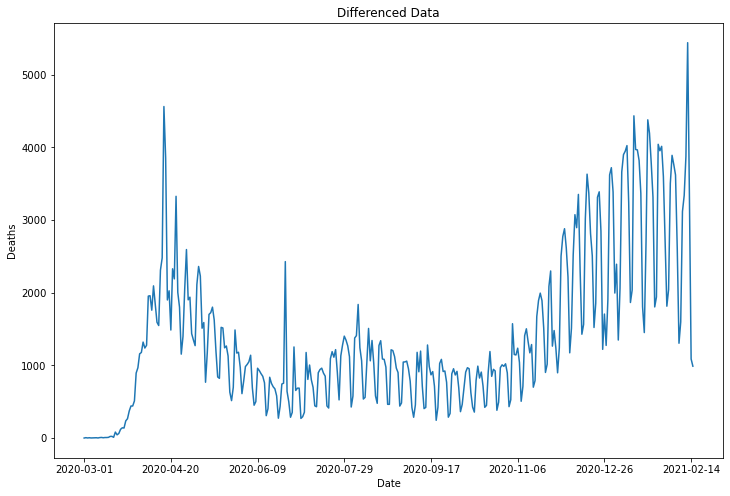

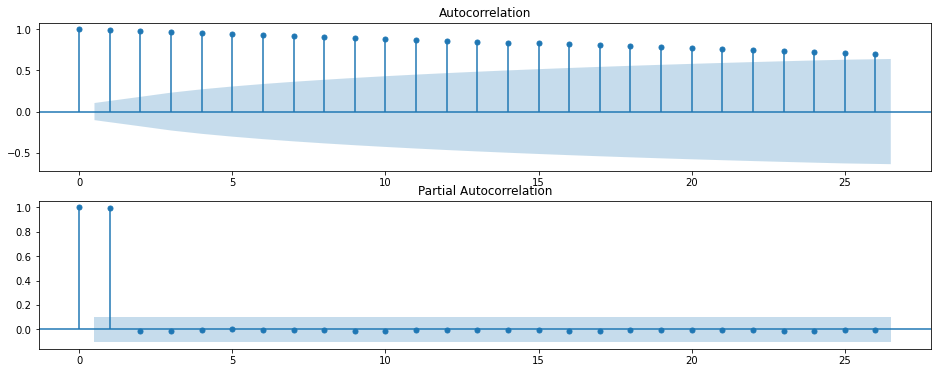

RMSE is 411.875 with ARIMA of (8, 2, 1)
RMSE is 408.708 with ARIMA of (9, 2, 1)
RMSE is 409.962 with ARIMA of (10, 2, 1)
RMSE is 407.305 with ARIMA of (10, 2, 2)
RMSE is 409.188 with ARIMA of (11, 2, 1)
RMSE is 408.769 with ARIMA of (11, 2, 2)

Best RMSE Score is 407.305 with ARIMA of (10, 2, 2)

RMSE: 407.305
       Residual Statistics
count           177.000000
mean             19.713566
std             407.982060
min           -1463.518360
25%            -187.115072
50%             -18.026391
75%             176.955189
max            1972.332750


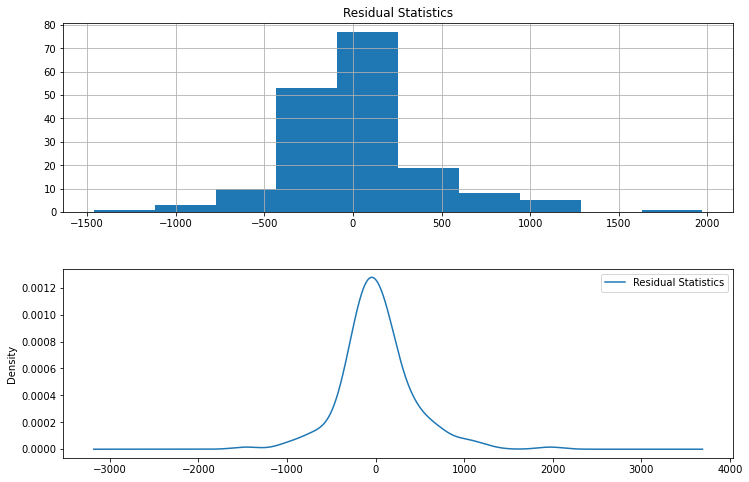


bias IS saved in arg_dict["bias"] for subsequent run is: 19.713565838150284 


RMSE: 406.828
       Residual Statistics
count         1.770000e+02
mean         -8.221421e-12
std           4.079821e+02
min          -1.483232e+03
25%          -2.068286e+02
50%          -3.773996e+01
75%           1.572416e+02
max           1.952619e+03


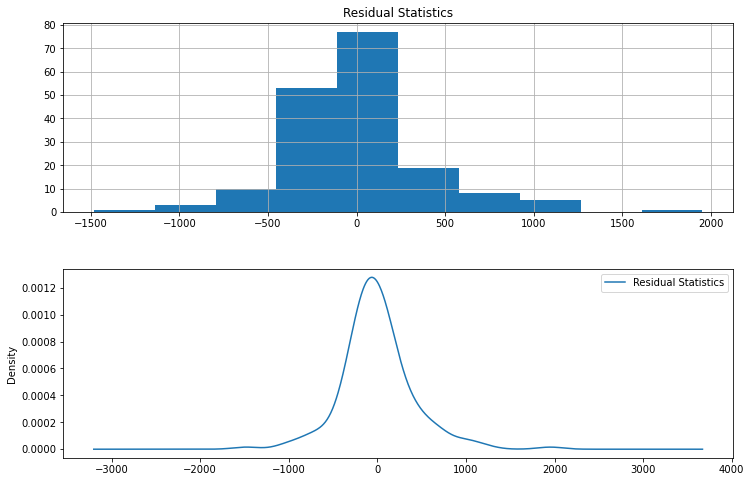


bias NOT saved in arg_dict["bias"] for subsequent run is: -8.221421032975623e-12 



In [3]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last file to establish the currency of the data.
# This is the only reason that I need df at this point.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
order_list = ags.driver(df, arg_dict)
arg_dict.update({'order_list': order_list})
arg_dict.update({'best_cfg': order_list[0]})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot test (actual) vs predictions, save, and forecast

The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 486,994


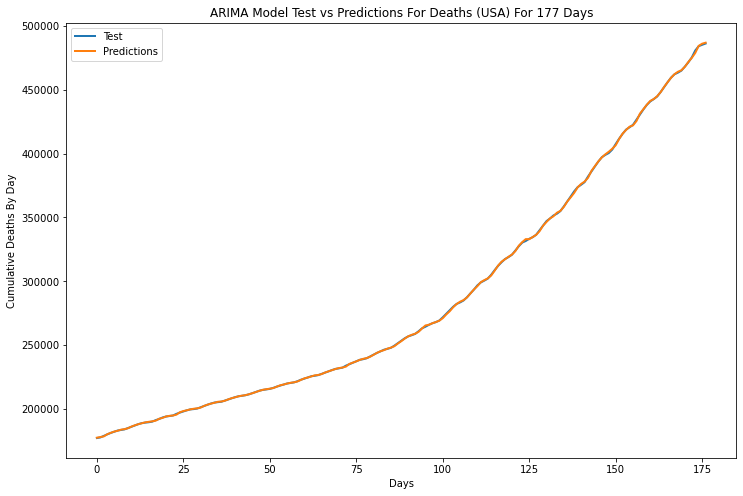

In [4]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi Step Forecast

The USA prediction is for 946,725 cumulative Deaths to occur by 2021-06-30 00:00:00


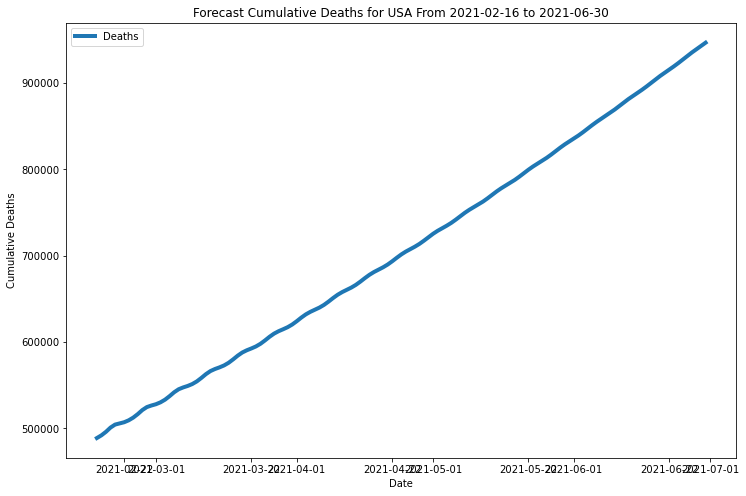

In [5]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

## Actual
If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [6]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.head() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-02-29,1.0,NaN
2020-03-01,1.0,0.0
2020-03-02,6.0,5.0
2020-03-03,7.0,1.0
2020-03-04,11.0,4.0


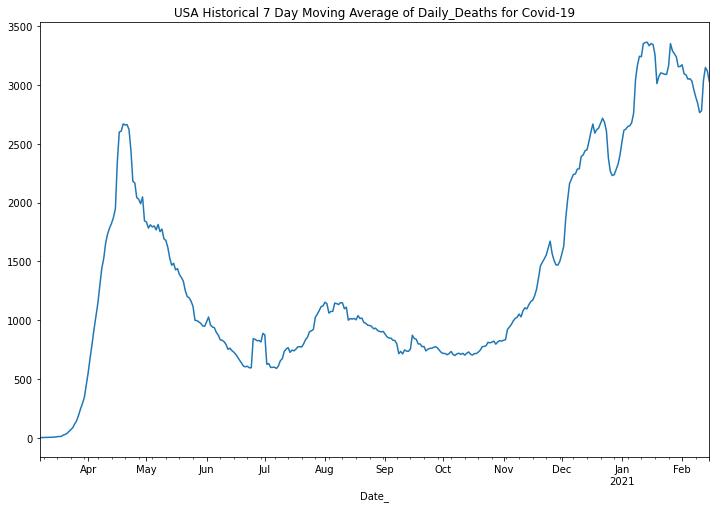

In [7]:
# Graph a 7 day rolling average rate
df['moving_average'] = df[new_col].rolling(7).mean()
df.dropna(inplace=True)
df['moving_average'] = df['moving_average'].astype(np.int)
title = arg_dict['place'] + ' Historical 7 Day Moving Average of ' + new_col + ' for Covid-19'
plt.title(title)
df['moving_average'].plot();

## 14 Day Forecast

In [8]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head(14)

Predicted


,Deaths,Daily_Deaths
Date_,,
2021-02-16,488831.0,2506.0
2021-02-17,491978.0,3147.0
2021-02-18,496045.0,4067.0
2021-02-19,500952.0,4907.0
2021-02-20,504397.0,3445.0
2021-02-21,505824.0,1427.0
2021-02-22,507122.0,1298.0
2021-02-23,509357.0,2235.0
2021-02-24,512483.0,3126.0


## Conclusions

- The code is quite flexible. It accepts any feature and will predict the values based on it. 

## Limitations

ARIMA is very sensitive to the most recent data. This is a feature of ARIMA models. This is probably not the best for long term predictions. However, it is also probably the best that we can do right now.